# Финальный проект. Игры — Анализ рекламных источников

### Задача:

#### Проанализируйте поведения игроков в зависимости от источника перехода.

Проанализируйте поведения игроков в зависимости от источника перехода.

    Проведите исследовательский анализ данных;
    Проанализируйте влияние источника перехода в игру на поведение пользователя;
    Проверьте статистические гипотезы
    
1. Проверьте гипотезу: время завершения уровня различается в зависимости способа прохождения:

     через реализацию проекта,
     
     через победу над первым игроком.

2. Сформулируйте собственную статистическую гипотезу. Дополните её нулевой и альтернативной гипотезами. Проверьте гипотезу с помощью статистического теста.

#### Заказчик исследования - маркетинговый отдел компании-разработчика

Содержание: 
<a class="anchor" id="num0"></a>

[Шаг 1. Загрузка данных и необходимых библиотек](#num1)</a>

[Шаг 2. Предобработка данных](#num2)</a>

[Шаг 3. Исследовательский анализ данных](#num3)</a>

[Шаг 4. Анализ влияния источника перехода в игру на поведение пользователя](#num4)</a>

[Шаг 5. Проверка статистических гипотез](#num5)</a>

[Шаг 6. Общие выводы](#num6)</a>

## Описание датасетов:

Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

    Победа над первым врагом
    
    Реализация проекта - разработка орбитальной сборки спутников
    
В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

#### Датасет game_actions.csv:


- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

Датасет *ad_cost.csv*:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет user_source.csv содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

In [1]:
# Баш-ячейка для апгрейда seaborn
!pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 285 kB 3.7 MB/s eta 0:00:01


### Ссылка на презентацию: https://drive.google.com/file/d/1mIlkO3bIPw-f3Hf3Qx3vuZ4b2GRxABvi/view?usp=sharing

### Ссылка на дашборд(набор №2): https://public.tableau.com/profile/eugene7944#!/vizhome/SpaceBrothersDash/Dashboard1

## <a class="anchor" id="num1"> [Шаг 1. Загрузка датасетов и необходимых библиотек](#num0)</a>

In [2]:
# Загрузка необходимых библиотек
import math as mth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Пути загрузки датасетов
filepath1 = '/datasets/ad_costs.csv'
filepath2 = '/datasets/game_actions.csv'
filepath3 = '/datasets/user_source.csv'

In [4]:
# Загрузка датасетов
ad_costs = pd.read_csv(filepath1)
game_actions = pd.read_csv(filepath2)
user_source = pd.read_csv(filepath3)

## <a class="anchor" id="num2">[Шаг 2. Предобработка данных](#num0)</a>

In [5]:
# Создадим функцию для изучения основной информации о датасете
def dataframe_info(column, data):
    display(data.sample(5))
    print(2*'\n')
    data.info()
    print(2*'\n')
    for column in data:
        print('Количество пропусков в столбце',
              column, ':', ((data[column].isna().sum() /
                             len(data[column])*100).round()),
              '%')

    print('В датасете обнаружено {} дубликатов'.format(data.duplicated().sum()))

In [6]:
# Посмотрим на датасет game_actions
dataframe_info(game_actions.columns, game_actions)

,event_datetime,event,building_type,user_id,project_type
94674,2020-05-13 00:31:06,building,spaceport,8cfe5de9-6305-4847-937c-3b938b88880c,NaN
106623,2020-05-14 15:26:16,building,research_center,7e9ff3c4-3234-491c-92fe-91463d2fff03,NaN
90229,2020-05-12 10:58:21,building,research_center,8cd92e81-ea87-4b78-85ce-459f162591b9,NaN
126614,2020-05-18 22:07:14,building,research_center,e2cd2203-3daf-4582-b24d-116306cf064e,NaN
13428,2020-05-05 14:12:03,building,assembly_shop,66cf245e-83a5-4f75-a19a-d719a7889738,NaN





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null object
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: object(5)
memory usage: 5.2+ MB



Количество пропусков в столбце event_datetime : 0.0 %
Количество пропусков в столбце event : 0.0 %
Количество пропусков в столбце building_type : 6.0 %
Количество пропусков в столбце user_id : 0.0 %
Количество пропусков в столбце project_type : 99.0 %
В датасете обнаружено 1 дубликатов


In [7]:
# Посмотрим на датасет ad_costs
dataframe_info(ad_costs.columns, ad_costs)

,source,day,cost
14,yandex_direct,2020-05-03,969.139394
18,yandex_direct,2020-05-07,114.429338
20,yandex_direct,2020-05-09,42.779505
15,yandex_direct,2020-05-04,554.651494
23,youtube_channel_reklama,2020-05-05,147.041741





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null object
cost      28 non-null float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes



Количество пропусков в столбце source : 0.0 %
Количество пропусков в столбце day : 0.0 %
Количество пропусков в столбце cost : 0.0 %
В датасете обнаружено 0 дубликатов


In [8]:
# Переименуем столбец (на будущее) и приведем формат object в формат datetime64
ad_costs = ad_costs.rename({'day': 'first_day'}, axis='columns')
ad_costs['first_day'] = pd.to_datetime(
    ad_costs['first_day'], format='%Y-%m-%d')
display(ad_costs.sample(5))

,source,first_day,cost
22,youtube_channel_reklama,2020-05-04,259.073224
0,facebook_ads,2020-05-03,935.882786
11,instagram_new_adverts,2020-05-07,109.915254
4,facebook_ads,2020-05-07,111.766796
17,yandex_direct,2020-05-06,180.917099


In [9]:
# Посмотрим на датасет user_source
dataframe_info(user_source.columns, user_source)

,user_id,source
13504,fe8247d6-4e01-424c-a37e-31978fe9dbb8,facebook_ads
11848,df952ed7-949f-4117-9755-b60e36c0f759,yandex_direct
4082,4b2b16f3-6216-40d9-975d-5062e1fab5b9,instagram_new_adverts
3077,383eaffd-ed08-4d67-bb9a-4ec94400655a,instagram_new_adverts
7322,88bd964d-8b6b-4216-b132-e3708b1f1b83,facebook_ads





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
user_id    13576 non-null object
source     13576 non-null object
dtypes: object(2)
memory usage: 212.2+ KB



Количество пропусков в столбце user_id : 0.0 %
Количество пропусков в столбце source : 0.0 %
В датасете обнаружено 0 дубликатов


#### Промежуточный вывод: загружено 3 датасета и изучены их свойства. Обнаружены следующие проблемы: пропуски и дубликаты в датасете game_actions, и формат даты в двух датасетах записан как object. Формат даты установлен datetime64, пропуски и дубликаты обработаны ниже.

Поработаем с датасетом game_actions

Поскольку столбец building_type не важен для решения поставленной задачи, то и пропуски заполнять не стоит, а можно его спокойно удалить. Ненулевые значение в столбце project_type помогают нам выделить строителей-пве'шников. 

In [10]:
event_project = game_actions[game_actions['event'] == 'project']
display(event_project['project_type'].value_counts())

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

Разделим всех игроков на строителей(pve), воинов(pvp) и "лузеров" (не закончили первый уровень). 

In [11]:
groups_query = game_actions.groupby('user_id').agg({'event': 'nunique'})
groups_query['event'] = groups_query['event'].replace(
    1, 'looser').replace(2, 'warrior').replace(3, 'builder')
groups_query = groups_query.rename({'event': 'groups'}, axis=1)
display(groups_query)

,groups
user_id,
0001f83c-c6ac-4621-b7f0-8a28b283ac30,looser
00151b4f-ba38-44a8-a650-d7cf130a0105,looser
001aaea6-3d14-43f1-8ca8-7f48820f17aa,looser
001d39dc-366c-4021-9604-6a3b9ff01e25,warrior
002f508f-67b6-479f-814b-b05f00d4e995,looser
...,...
ffef4fed-164c-40e1-bde1-3980f76d0fb5,warrior
fffab3da-da0e-4e30-ae62-10d0a2e24a4e,looser
fffb626c-5ab6-47c9-8113-2062a2f18494,warrior


Комментарий для понимания:

    1. Строителями (builder) являются игроки имеющие 3 уникальных действия в столбце event(building, project, finished_stage_1);
    2. Воинами (warrior) являются игроки без уникального действия project в столбце event;
    3. "Лузерами"(looser) являются игроки не завершившие первый уровень

In [12]:
# Обновим датасет game_actions
game_actions = game_actions.merge(groups_query, on='user_id')
game_actions = game_actions.drop(['building_type', 'project_type'], axis=1)
display(game_actions)

,event_datetime,event,user_id,groups
0,2020-05-04 00:00:01,building,55e92310-cb8e-4754-b622-597e124b03de,looser
1,2020-05-05 05:20:15,building,55e92310-cb8e-4754-b622-597e124b03de,looser
2,2020-05-05 19:24:02,building,55e92310-cb8e-4754-b622-597e124b03de,looser
3,2020-05-05 20:59:19,building,55e92310-cb8e-4754-b622-597e124b03de,looser
4,2020-05-06 00:52:56,building,55e92310-cb8e-4754-b622-597e124b03de,looser
...,...,...,...,...
135635,2020-05-13 23:56:39,building,cafd1b8b-507b-49ae-abf0-89fe863a8b03,looser
135636,2020-05-18 00:23:28,building,cafd1b8b-507b-49ae-abf0-89fe863a8b03,looser
135637,2020-05-10 23:59:52,building,bdc53e19-462a-4dc3-8b55-b4a34278af6a,looser
135638,2020-05-13 08:11:19,building,bdc53e19-462a-4dc3-8b55-b4a34278af6a,looser


In [13]:
game_actions = game_actions.drop_duplicates()

In [14]:
game_actions['event_datetime'] = pd.to_datetime(
    game_actions['event_datetime'], format='%Y-%m-%dT%H:%M:%S')

In [15]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 4 columns):
event_datetime    135639 non-null datetime64[ns]
event             135639 non-null object
user_id           135639 non-null object
groups            135639 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 5.2+ MB


#### Промежуточный вывод: получен "чистый" датасет game_actions без пропусков и дубликатов формат даты изменен с object на datetime64. В датасете user_source проблем не обнаружено. В датасете ad_costs для столбца first_day тип данных изменен с object на datetime64.

### <a class="anchor" id="num3">[Шаг 3. Исследовательский анализ данных](#num0)</a>

In [16]:
# Объединим таблички game_actions и user_source для дальнейшей работы
final_data = game_actions.merge(user_source, on='user_id')
display(final_data)

,event_datetime,event,user_id,groups,source
0,2020-05-04 00:00:01,building,55e92310-cb8e-4754-b622-597e124b03de,looser,youtube_channel_reklama
1,2020-05-05 05:20:15,building,55e92310-cb8e-4754-b622-597e124b03de,looser,youtube_channel_reklama
2,2020-05-05 19:24:02,building,55e92310-cb8e-4754-b622-597e124b03de,looser,youtube_channel_reklama
3,2020-05-05 20:59:19,building,55e92310-cb8e-4754-b622-597e124b03de,looser,youtube_channel_reklama
4,2020-05-06 00:52:56,building,55e92310-cb8e-4754-b622-597e124b03de,looser,youtube_channel_reklama
...,...,...,...,...,...
135634,2020-05-13 23:56:39,building,cafd1b8b-507b-49ae-abf0-89fe863a8b03,looser,facebook_ads
135635,2020-05-18 00:23:28,building,cafd1b8b-507b-49ae-abf0-89fe863a8b03,looser,facebook_ads
135636,2020-05-10 23:59:52,building,bdc53e19-462a-4dc3-8b55-b4a34278af6a,looser,youtube_channel_reklama
135637,2020-05-13 08:11:19,building,bdc53e19-462a-4dc3-8b55-b4a34278af6a,looser,youtube_channel_reklama


#### 1)  Посчитать конверсию игроков завершивших первый уровень в разрезе pve/pvp

In [17]:
# Общее количество игроков
total_players = final_data['user_id'].nunique()
display('Общее количество игроков равно {}'.format(total_players))

'Общее количество игроков равно 13576'

In [18]:
# Количество игроков завершивших первый уровень
level_1_win = final_data[final_data['groups'] != 'looser']['user_id'].nunique()
print('Количество игроков, завершивших 1 уровень составляет {}'.format(level_1_win))

Количество игроков, завершивших 1 уровень составляет 5817


In [19]:
# Конверсия общего числа игроков
conversion = np.round(((level_1_win / total_players)*100))
print('Конверсия игроков из новичка в прошедшего 1 уровень составляет {} %'.format(conversion))

Конверсия игроков из новичка в прошедшего 1 уровень составляет 43.0 %


In [20]:
# Конверсия игроков в разрезе pve/pvp
pvp_players = final_data[final_data['groups']
                         == 'warrior']['user_id'].nunique()
pve_players = final_data[final_data['groups']
                         == 'builder']['user_id'].nunique()

pve_conv = np.round((pve_players / total_players)*100)
pvp_conv = np.round((pvp_players / total_players)*100)

print('Конверсия успешных pve-игроков составляет {} %'.format(pve_conv))
print('Конверсия успешных pvp-игроков составляет {} %'.format(pvp_conv))

Конверсия успешных pve-игроков составляет 14.0 %
Конверсия успешных pvp-игроков составляет 29.0 %


In [21]:
# Создадим данные для визуализации
vis1 = final_data.groupby('groups')['user_id'].nunique().reset_index()
vis2 = vis1[vis1['groups'] != 'looser']

group_dict = {'builder': 'строитель',
              'warrior': 'воин',
              'looser': 'лузер'}

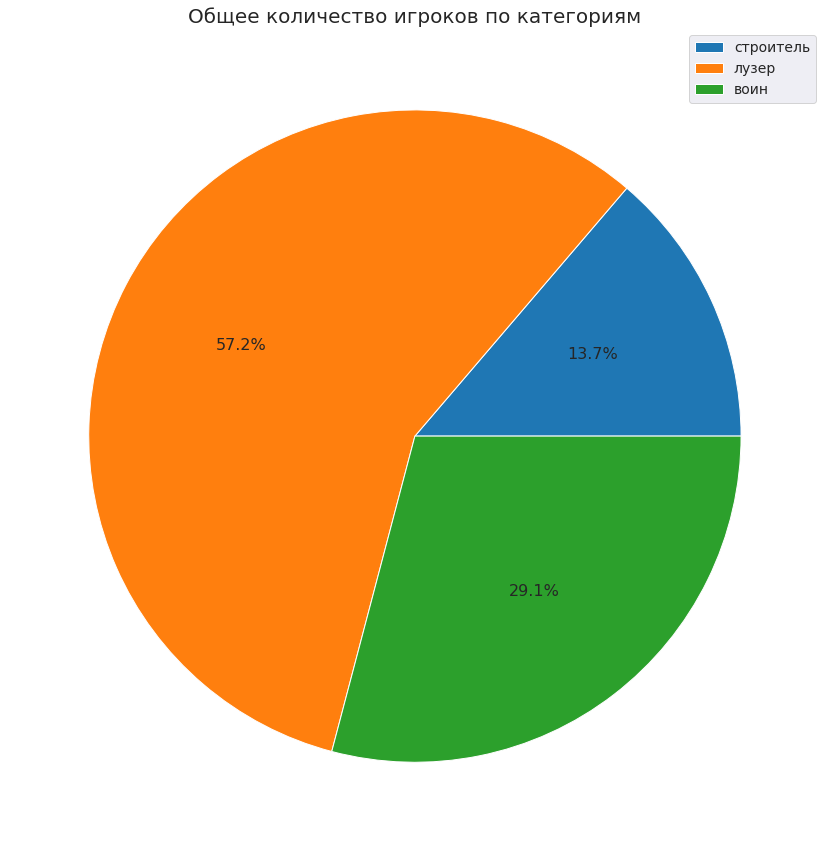

In [22]:
# Построим общее соотношение всех игроков
plt.figure(figsize=(15, 15))
sns.set_style('darkgrid')
plt.pie(vis1['user_id'],
        labels=None,
        autopct='%1.1f%%',
        textprops={'fontsize': 16}
        )
plt.legend(vis1['groups'].map(group_dict), fontsize=14)
plt.title('Общее количество игроков по категориям', fontsize=20)
#plt.savefig('total_categories.png', dpi=200, bbox_inches='tight')
plt.show()

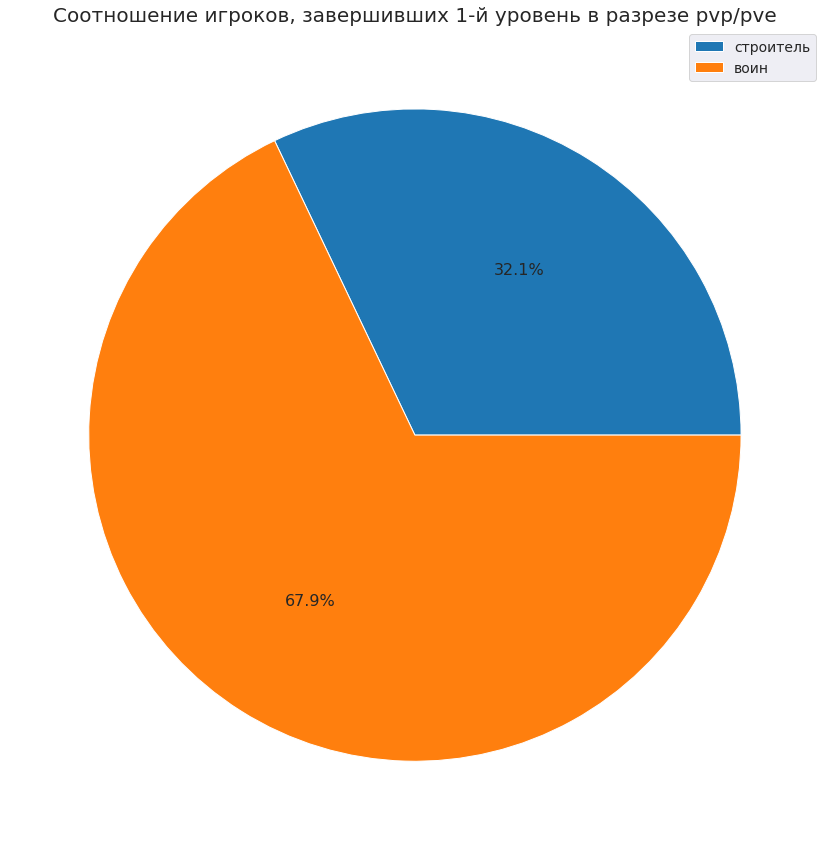

In [23]:
# Построим соотношение воинов к строителям
plt.figure(figsize=(15, 15))
plt.pie(vis2['user_id'],
        labels=None,
        autopct='%1.1f%%',
        textprops={'fontsize': 16}
        )
plt.legend(vis2['groups'].map(group_dict), fontsize=14)
plt.title(
    'Соотношение игроков, завершивших 1-й уровень в разрезе pvp/pve', fontsize=20)
#plt.savefig('pvp_pve.png', dpi=200, bbox_inches='tight')
plt.show()

#### Промежуточный вывод: Конверсия из новичков в игроков, завершивших 1-й уровень составляет 43%. Из них pvp-игроков примерно в 2 раза больше. Предположительно повысить конверсию можно введением обучения в игру.

#### 2) Изучить количество игроков привлеченных каждым источником рекламы и среднюю стоимость их привлечения 

In [24]:
users_count_sum = final_data.groupby(
    ['source'])['user_id'].nunique().reset_index()
display(users_count_sum.sort_values(by='user_id', ascending=False))

,source,user_id
2,yandex_direct,4817
1,instagram_new_adverts,3347
0,facebook_ads,2726
3,youtube_channel_reklama,2686


Наибольшее количество игроков привлечено с помощью Яндекс.Директ, наименьшее - с помощью рекламы с Youtube.

Посчитаем какой источник рекламы дороже/дешевле всех в абсолютных величинах и среднюю стоимость привлечения игрока из каждого источника

In [25]:
ad_costs_grouped = (ad_costs.groupby('source')[
                    'cost'].sum().reset_index()).round(2)

In [26]:
mean_costs = pd.merge(ad_costs_grouped, users_count_sum, on='source')
mean_costs['mean'] = (mean_costs['cost'] / mean_costs['user_id']).round(2)
display(mean_costs)

,source,cost,user_id,mean
0,facebook_ads,2140.90,2726,0.79
1,instagram_new_adverts,2161.44,3347,0.65
2,yandex_direct,2233.11,4817,0.46
3,youtube_channel_reklama,1068.12,2686,0.40


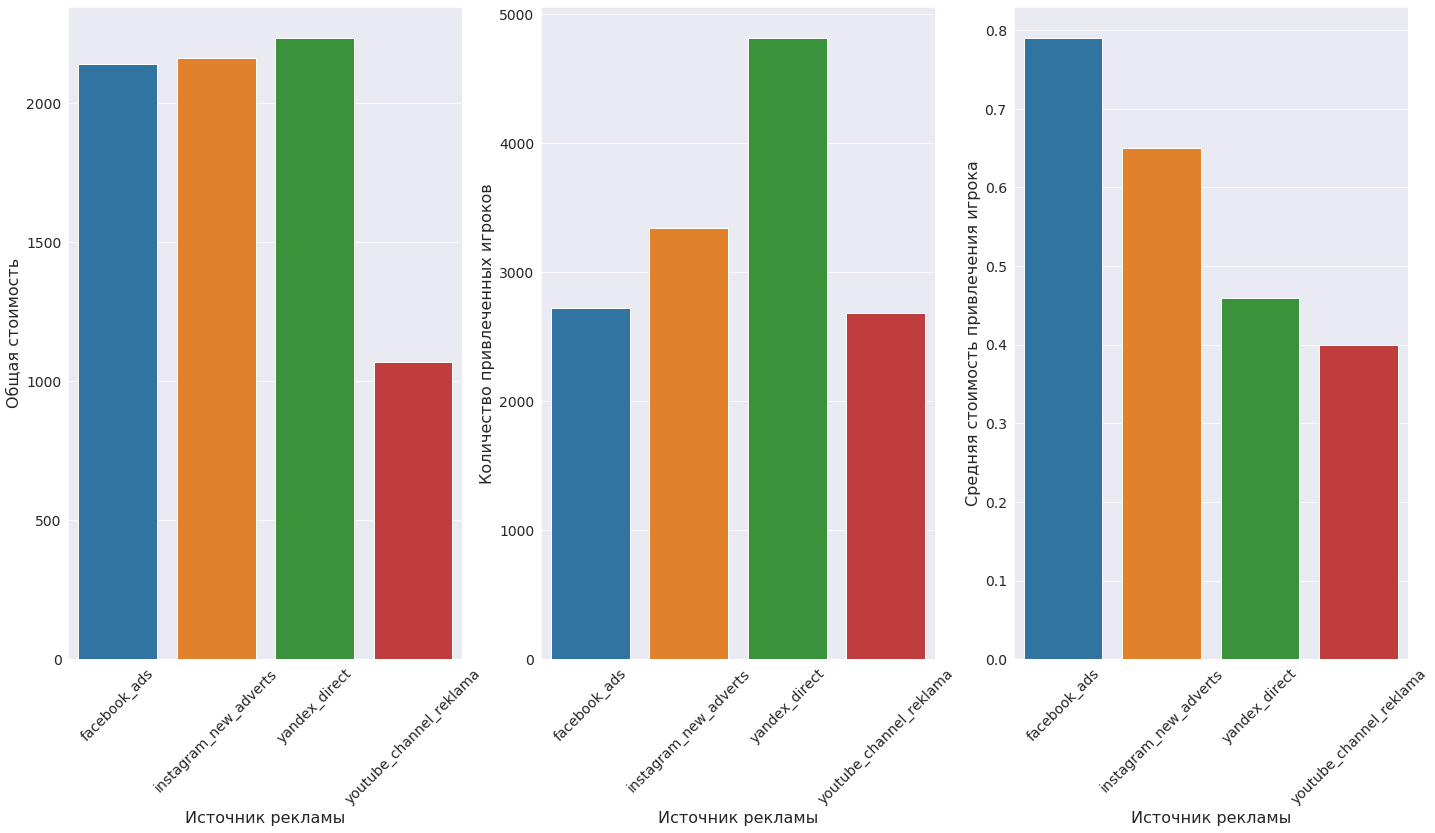

In [27]:
# Построим визуализацию
fig = plt.figure(figsize=(24, 12))
sns.set_style('darkgrid')

ax_1 = fig.add_subplot(1, 3, 1)
ax1 = sns.barplot(data=mean_costs, x='source', y='cost')
ax1.set_xlabel('Источник рекламы', fontsize=16)
ax1.set_ylabel('Общая стоимость', fontsize=16)
ax1.tick_params(axis='x', which='major', labelsize=14, labelrotation=45)
ax1.tick_params(axis='y', which='major', labelsize=14)

ax_2 = fig.add_subplot(1, 3, 2)
ax2 = sns.barplot(data=mean_costs, x='source', y='user_id')
ax2.set_xlabel('Источник рекламы', fontsize=16)
ax2.set_ylabel('Количество привлеченных игроков', fontsize=16)
ax2.tick_params(axis='x', which='major', labelsize=14, labelrotation=45)
ax2.tick_params(axis='y', which='major', labelsize=14)

ax_3 = fig.add_subplot(1, 3, 3)
ax3 = sns.barplot(data=mean_costs, x='source', y='mean')
ax3.set_xlabel('Источник рекламы', fontsize=16)
ax3.set_ylabel('Средняя стоимость привлечения игрока', fontsize=16)
ax3.tick_params(axis='x', which='major', labelsize=14, labelrotation=45)
ax3.tick_params(axis='y', which='major', labelsize=14)

#plt.savefig('sources1.png', dpi=200, bbox_inches='tight')
plt.show()

#### Промежуточный вывод: В абсолютных величинах самым дорогостоящим оказался Яндекс.Директ, но и привлек большее количество игроков. Менее затратным оказалась реклама с Youtube, и с его помощью привлечено меньшее количество игроков. По средней стоимости затрат на привлечение одного игрока лидирует Youtube, Facebook оказался самым дорогим. Яндекс.Директ показал результат не сильно хуже, чем Youtube.

#### 3) Оценить количество и долю игроков не завершивших первый уровень игры в разрезе источников рекламы.

In [28]:
# Посчитаем количество таких игроков
loosers = total_players - level_1_win
print('Количество игроков, не завершивших первый уровень составило {}'.format(loosers))

# В разрезе рекламных источников
loosers_grouped = ((final_data[final_data['groups'] == 'looser'])
                   .groupby('source').agg({'user_id': 'nunique'})).reset_index()
loosers_grouped = loosers_grouped.rename({'user_id': 'los_count'}, axis=1)

mean_costs = mean_costs.merge(loosers_grouped, on='source')
display(mean_costs)

Количество игроков, не завершивших первый уровень составило 7759


,source,cost,user_id,mean,los_count
0,facebook_ads,2140.90,2726,0.79,1576
1,instagram_new_adverts,2161.44,3347,0.65,1881
2,yandex_direct,2233.11,4817,0.46,2775
3,youtube_channel_reklama,1068.12,2686,0.40,1527


In [29]:
# Найдем долю игроков-лузеров от общего количества игроков привлеченных рекламой
mean_costs['loose_share'] = (
    mean_costs['los_count'] / mean_costs['user_id']).round(2)
display(mean_costs)

,source,cost,user_id,mean,los_count,loose_share
0,facebook_ads,2140.90,2726,0.79,1576,0.58
1,instagram_new_adverts,2161.44,3347,0.65,1881,0.56
2,yandex_direct,2233.11,4817,0.46,2775,0.58
3,youtube_channel_reklama,1068.12,2686,0.40,1527,0.57


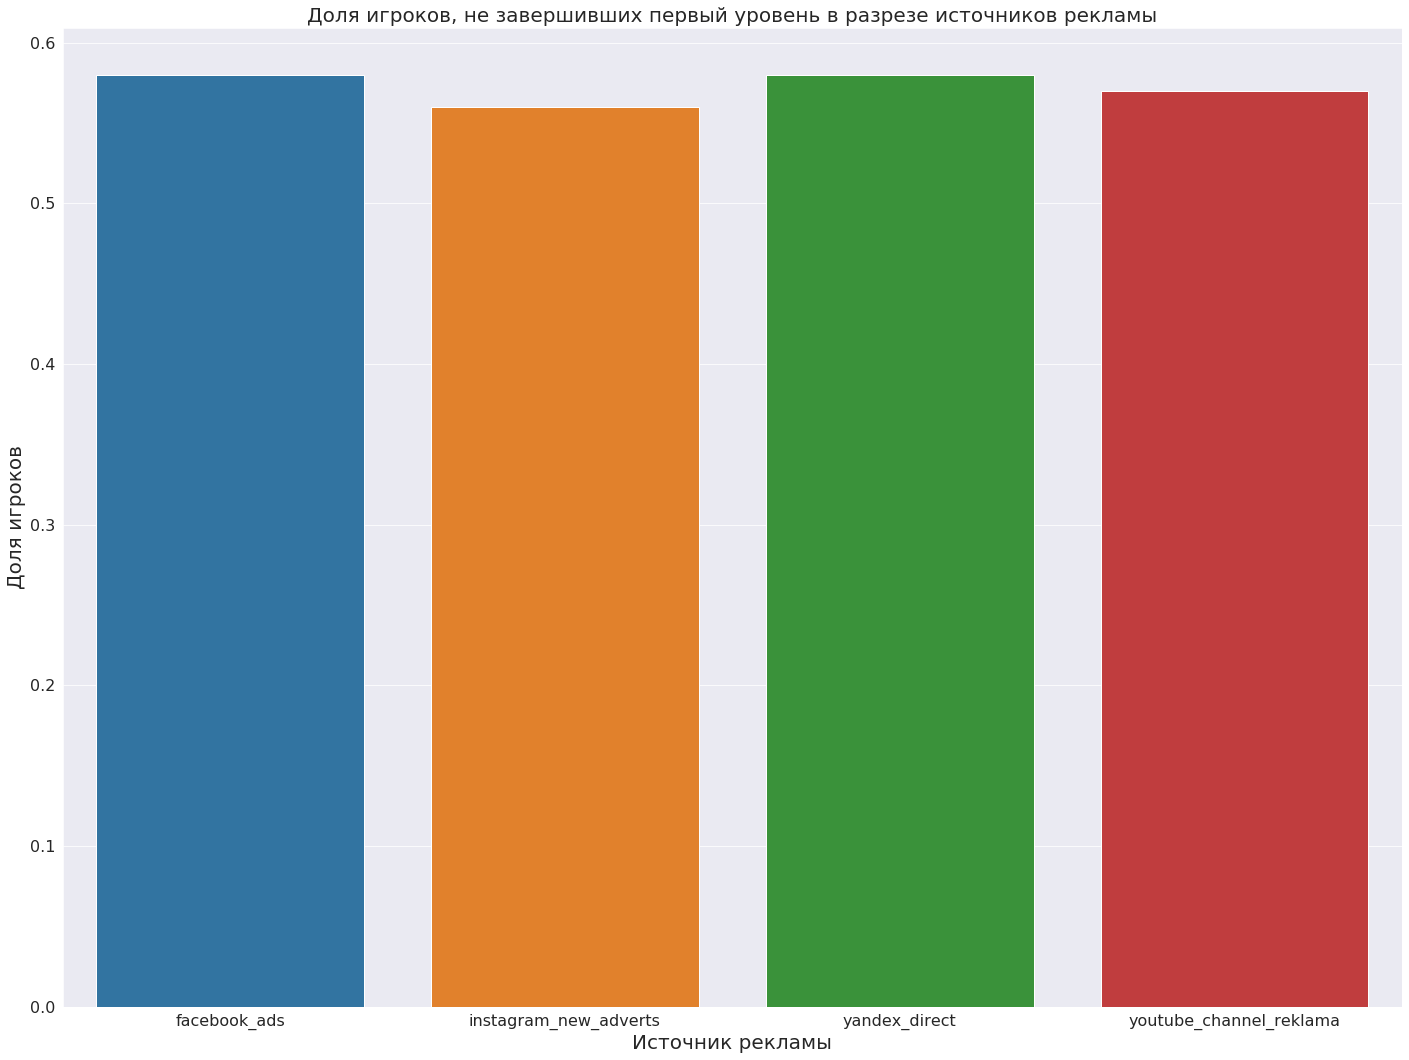

In [30]:
# Построим визуализацию
plt.figure(figsize=(24, 18))
sns.set_style('darkgrid')
sns.barplot(data=mean_costs, x='source', y='loose_share')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Доля игроков, не завершивших первый уровень в разрезе источников рекламы', fontsize=20)
plt.xlabel('Источник рекламы', fontsize=20)
plt.ylabel('Доля игроков', fontsize=20)
#plt.savefig('loosers_sources.png', dpi=200, bbox_inches='tight')
plt.show()

#### Промежуточный вывод: Доля игроков пришедших из разных источников рекламы примерно одинакова.

## <a class="anchor" id="num4">[Шаг 4. Анализ влияния источника перехода в игру на поведение пользователя](#num0)</a>

#### 1) Методом когортного анализа посчитать время прошедшее от первого дня игры до завершения уровня (с разделением по типу прохождения)

In [31]:
# Выделим столбец с днём совершения действия в игре
final_data['day'] = final_data['event_datetime'].astype('datetime64[D]')

In [32]:
# Выделим столбец с датой, когда игрок начал играть
first_day = final_data.groupby('user_id')['day'].min()
first_day.name = 'first_day'

In [33]:
display(first_day.sample(5))

user_id
d0cdbe24-0f2c-4f45-92a0-dc96e39072e1   2020-05-04
3deadb0e-26f4-4bd7-9a6c-b6f4ac1be865   2020-05-04
ad0a37cc-4666-442e-9583-43598366c729   2020-05-06
65526dd2-2a0b-4bd6-a5d0-b16edeed11c4   2020-05-07
33ebb3af-129f-41b6-8a16-a218b9243648   2020-05-04
Name: first_day, dtype: datetime64[ns]

In [34]:
# Присоединим столбец с датой начала игры к основному датасету
final_data = pd.merge(final_data, first_day, on='user_id')

In [35]:
display(final_data.sample(5))

,event_datetime,event,user_id,groups,source,day,first_day
110306,2020-05-11 09:59:42,building,a4279086-89c9-4720-8e19-edd36dbcb234,looser,facebook_ads,2020-05-11,2020-05-06
82834,2020-05-05 18:59:40,building,d2ca898f-152e-422f-921a-3dcb21be19ca,looser,instagram_new_adverts,2020-05-05,2020-05-05
16823,2020-05-08 07:57:48,building,08c709b0-2a01-4148-9064-b46e30ca2406,warrior,yandex_direct,2020-05-08,2020-05-04
117401,2020-05-12 14:16:43,building,1eccbf37-467d-4df7-a2a3-89ee373bbfca,looser,youtube_channel_reklama,2020-05-12,2020-05-07
6954,2020-05-11 12:27:28,building,ffef4fed-164c-40e1-bde1-3980f76d0fb5,warrior,instagram_new_adverts,2020-05-11,2020-05-04


In [36]:
# Скачивание датасета для подготовки дашборда
#final_data.to_csv(r'C:\Users\Torberg\Documents\Yandex Projects\final_project\dash_data.csv', index=False)

In [37]:
# Выделим срез с игроками завершившими первый уровень
final_data_query = final_data[final_data['event'] == 'finished_stage_1']

In [38]:
display(final_data_query.sample(5))

,event_datetime,event,user_id,groups,source,day,first_day
63663,2020-05-15 21:29:53,finished_stage_1,5b5810fb-8c08-48fa-a1b4-36c4f98d7fa7,builder,youtube_channel_reklama,2020-05-15,2020-05-04
116778,2020-05-16 17:06:47,finished_stage_1,5ebbf925-f813-4c68-bb20-adcbf6bd9c0d,warrior,instagram_new_adverts,2020-05-16,2020-05-07
49257,2020-05-20 04:16:12,finished_stage_1,101152c2-81ad-4f8b-a9cf-6b8f129832a1,builder,instagram_new_adverts,2020-05-20,2020-05-04
76224,2020-05-18 09:29:04,finished_stage_1,a31272a4-a637-40d2-a59e-f76ef03c6b4b,warrior,youtube_channel_reklama,2020-05-18,2020-05-05
128204,2020-05-11 04:47:19,finished_stage_1,6aeb02cb-ad96-4877-9110-b38bfc6f96a8,warrior,facebook_ads,2020-05-11,2020-05-08


In [39]:
# Найдем время прохождения первого уровня
final_data_query['lifetime'] = (
    final_data_query['day'] - final_data_query['first_day']) / np.timedelta64(1, 'D')
final_data_query['lifetime'] = final_data_query['lifetime'].astype('int')

In [40]:
display(final_data_query.sample(5))

,event_datetime,event,user_id,groups,source,day,first_day,lifetime
24230,2020-05-17 15:44:36,finished_stage_1,456cc6a5-0a85-4c5a-b09c-559f838eec7e,builder,youtube_channel_reklama,2020-05-17,2020-05-04,13
10717,2020-05-17 22:26:30,finished_stage_1,3cbaa641-af12-46b9-9469-21e623145fa9,builder,instagram_new_adverts,2020-05-17,2020-05-04,13
71844,2020-05-11 07:53:28,finished_stage_1,2e3aa682-9399-4ddf-9df3-186efe9f9fbb,warrior,yandex_direct,2020-05-11,2020-05-05,6
65011,2020-05-18 17:31:41,finished_stage_1,dbdc1ec1-a851-4cc1-b107-b32555c3b799,builder,yandex_direct,2020-05-18,2020-05-05,13
16645,2020-05-19 10:08:21,finished_stage_1,665bba56-479a-407b-8879-3527889d9924,warrior,youtube_channel_reklama,2020-05-19,2020-05-04,15


In [41]:
# Выделим срезы для игроков строителей и воинов
pve = final_data_query[final_data_query['groups'] == 'builder']
pvp = final_data_query[final_data_query['groups'] == 'warrior']

<Figure size 432x288 with 0 Axes>

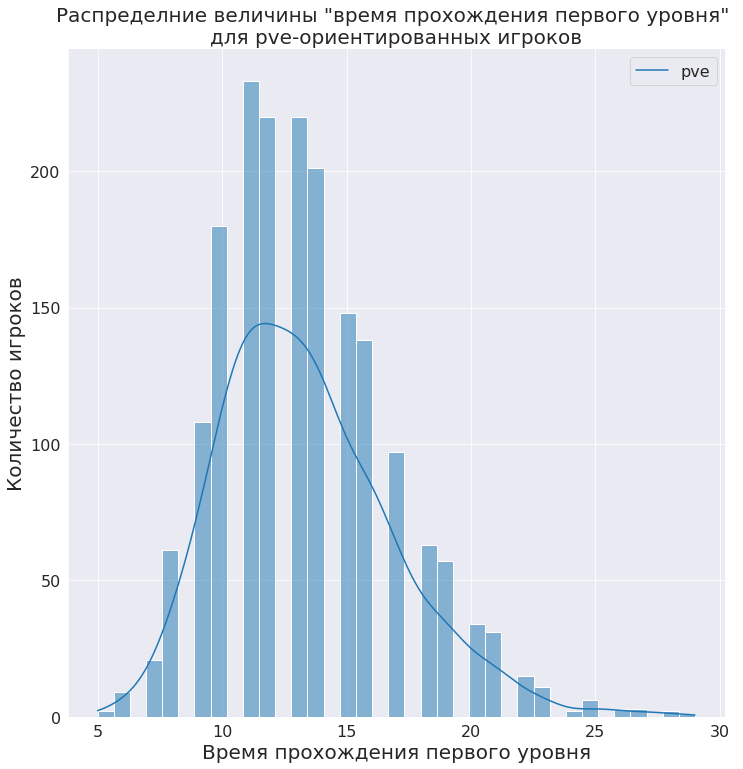

In [42]:
# Посмотрим на распределение величины "время прохождения первого уровня" для строителей
plt.figure()
sns.set_style('darkgrid')
sns.displot(pve, x=pve['lifetime'].astype('int'), kde=True, height=10)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Распределние величины "время прохождения первого уровня" \nдля pve-ориентированных игроков', fontsize=20)
plt.xlabel('Время прохождения первого уровня', fontsize=20)
plt.ylabel('Количество игроков', fontsize=20)
plt.legend(labels=['pve'], fontsize=16)
#plt.savefig('pve_lifetime.png', dpi=200, bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

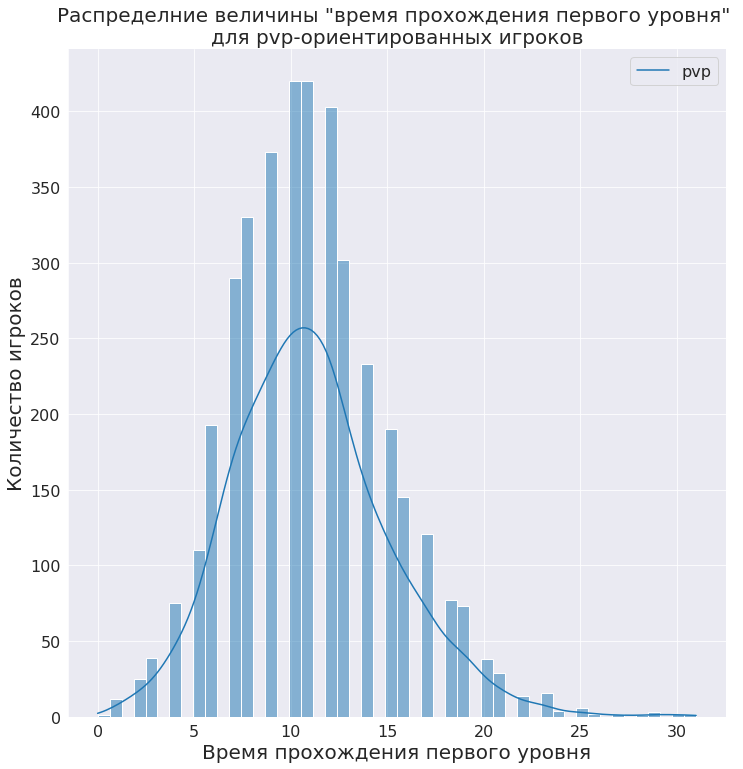

In [43]:
# Посмотрим на распределение величины "время прохождения первого уровня" для воинов
plt.figure()
sns.set_style('darkgrid')
sns.displot(pvp, x=pvp['lifetime'].astype('int'), kde=True, height=10)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Распределние величины "время прохождения первого уровня" \nдля pvp-ориентированных игроков', fontsize=20)
plt.xlabel('Время прохождения первого уровня', fontsize=20)
plt.ylabel('Количество игроков', fontsize=20)
plt.legend(labels=['pvp'], fontsize=16)
#plt.savefig('pvp_lifetime.png', dpi=200, bbox_inches='tight')
plt.show()

#### Промежуточный вывод: Полученные распределения близки к нормальному, поэтому среднее значения и медиана примерно равны друг другу. Но для оценки времени прохождения я выберу медиану - она более устойчива к выбросам.

In [44]:
display(final_data_query.groupby('groups')['lifetime'].median())

groups
builder    13
warrior    11
Name: lifetime, dtype: int64

#### Промежуточный вывод: среднее время прохождения для pve-игроков(строители) больше, чем для pvp-игроков(воины) - 13 дней против 11 дней.

#### 2) Оценить метрику САС для каждого источника рекламы

In [45]:
# Посчитаем количество новых игроков за каждый последующий день
new_players = final_data.groupby(['first_day', 'source']).agg(
    {'user_id': 'nunique'}).reset_index()
new_players = new_players.rename({'user_id': 'n_users'}, axis=1)
display(new_players.head(4))

,first_day,source,n_users
0,2020-05-04,facebook_ads,1184
1,2020-05-04,instagram_new_adverts,1452
2,2020-05-04,yandex_direct,2078
3,2020-05-04,youtube_channel_reklama,1146


In [46]:
# Приклеим к полученной таблице таблицу ad_costs
new_players = new_players.merge(ad_costs, on=['first_day', 'source'])
new_players['cost'] = new_players['cost'].round(2)
display(new_players.head(10))

,first_day,source,n_users,cost
0,2020-05-04,facebook_ads,1184,548.35
1,2020-05-04,instagram_new_adverts,1452,502.93
2,2020-05-04,yandex_direct,2078,554.65
3,2020-05-04,youtube_channel_reklama,1146,259.07
4,2020-05-05,facebook_ads,694,260.19
5,2020-05-05,instagram_new_adverts,796,313.97
6,2020-05-05,yandex_direct,1208,308.23
7,2020-05-05,youtube_channel_reklama,663,147.04
8,2020-05-06,facebook_ads,345,177.98
9,2020-05-06,instagram_new_adverts,472,173.07


In [47]:
# Посчитаем среднее значение САС покогортно
new_players['cac'] = new_players['cost'] / new_players['n_users']
new_players['cac'] = new_players['cac'].round(2)
display(new_players.head(10))

,first_day,source,n_users,cost,cac
0,2020-05-04,facebook_ads,1184,548.35,0.46
1,2020-05-04,instagram_new_adverts,1452,502.93,0.35
2,2020-05-04,yandex_direct,2078,554.65,0.27
3,2020-05-04,youtube_channel_reklama,1146,259.07,0.23
4,2020-05-05,facebook_ads,694,260.19,0.37
5,2020-05-05,instagram_new_adverts,796,313.97,0.39
6,2020-05-05,yandex_direct,1208,308.23,0.26
7,2020-05-05,youtube_channel_reklama,663,147.04,0.22
8,2020-05-06,facebook_ads,345,177.98,0.52
9,2020-05-06,instagram_new_adverts,472,173.07,0.37


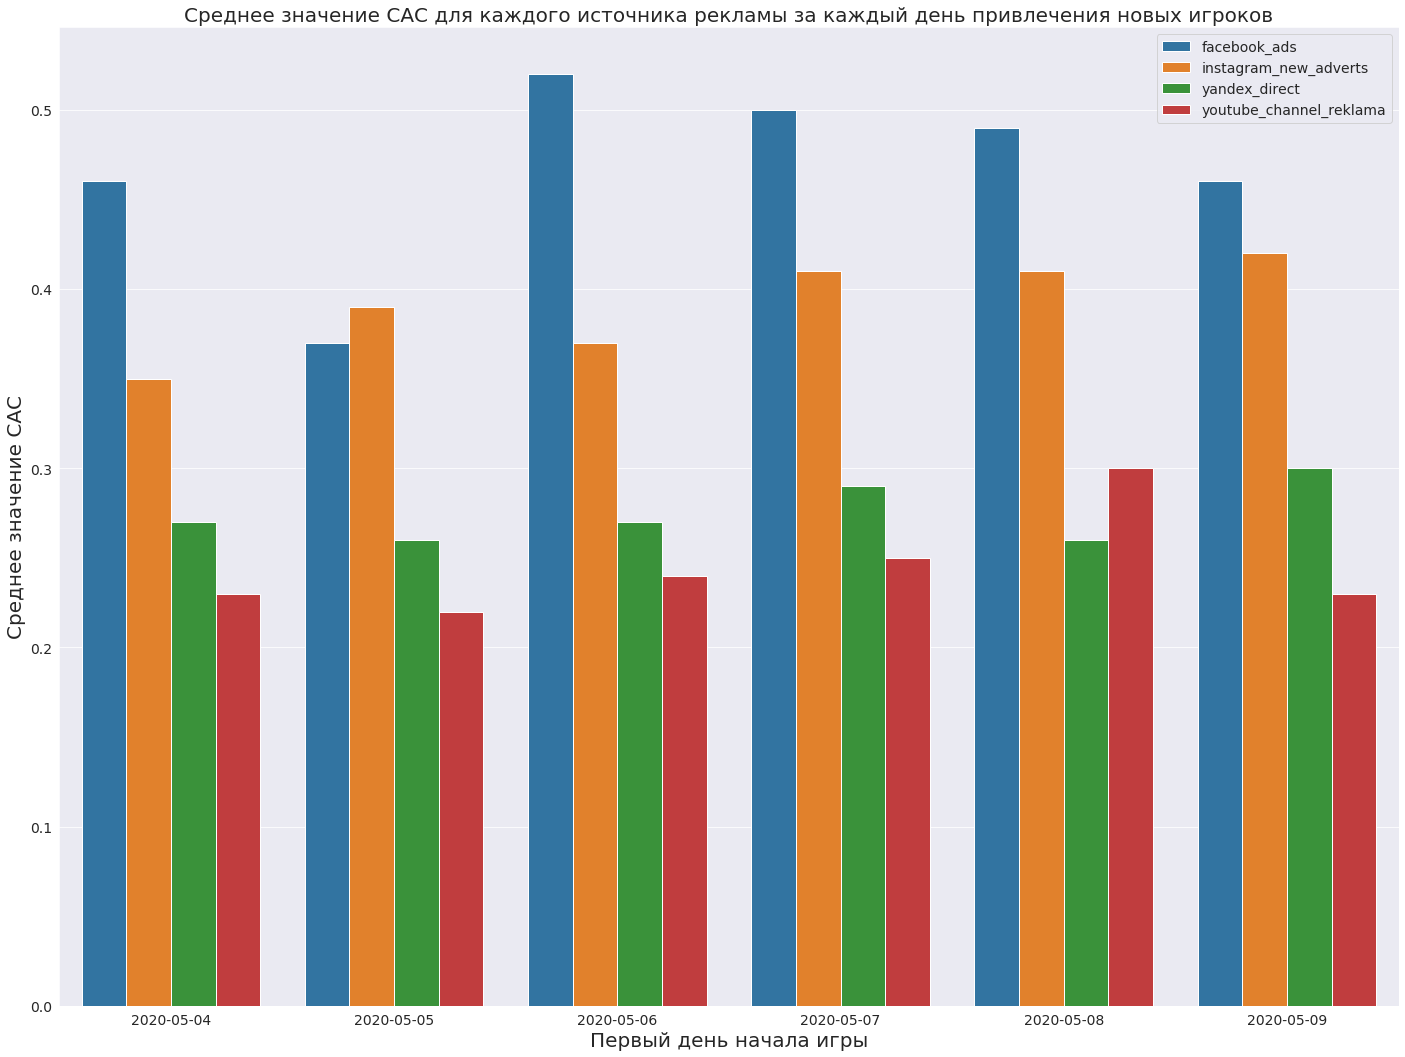

In [48]:
# Посмотрим на метрику САС в разрезе источников рекламы
plt.figure(figsize=(24, 18))
sns.set_style('darkgrid')
sns.barplot(data=new_players,
            x=new_players['first_day'].dt.strftime('%Y-%m-%d'),
            y='cac',
            hue='source'
            )
plt.tick_params(axis='both',
                which='major',
                labelsize=14)
plt.title('Среднее значение САС для каждого источника рекламы за каждый день привлечения новых игроков',
          fontsize=20)
plt.xlabel('Первый день начала игры', fontsize=20)
plt.ylabel('Среднее значение САС', fontsize=20)
plt.legend(fontsize=14)
#plt.savefig('CAC.png', dpi=200, bbox_inches='tight')
plt.show()

#### Промежуточный вывод: по значению метрики САС можно сделать следующий вывод: самым выгодным источником рекламы является платформы Youtube и Яндекс.Директ, самым невыгодным источником по стоимости привлечения является Facebook.

## <a class="anchor" id="num5">[Шаг 5. Проверка статистических гипотез](#num0)</a>

##### 1) Время завершения первого уровня различается в зависимости способа прохождения

Нулевая гипотеза Н0: среднее время прохождения первого уровня завершением проекта равно времени прохождения победой над другим игроком.

Альтернативная гипотеза Н1: время прохождения первого уровня разными способами отличается

Критический уровень статистической значимости: alpha = 0.05

In [49]:
# Подготовим 2 выборки для проведения статистического теста
sample_1 = final_data_query[final_data_query['groups']
                            == 'builder']['lifetime']
sample_2 = final_data_query[final_data_query['groups']
                            == 'warrior']['lifetime']

In [50]:
# Проверка равнства дисперсии проверяемых совокупностей для определения параметра equal_var
print(np.var(sample_1, ddof=1))
print(np.var(sample_2, ddof=1))

12.408867586757813
16.849998558288398


Дисперсии этих выборок не равны, поэтому для проверки статистической гипотезы используем t-тест Уэлча (параметр equal_var выбираем False)

In [51]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(sample_1, sample_2, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 6.570466755643636e-105
Отвергаем нулевую гипотезу


#### Промежуточный вывод: Нулевая гипотеза отвергается, следовательно время прохождения уровня разными способами различается (воины завершают уровень на 2 дня быстрее)

##### 2) Для ответа на вопрос задания "проанализируйте влияния источника перехода в игру на поведение пользователя" выдвигается следующая гипотеза: Рекламный источник перехода в игру влияет на поведение игрока.

Пояснение: для подтверждения/опровержения данной гипотезы проводится ряд z-тестов для сравнения долей pvp/pve-игроков, чтобы сделать вывод о влиянии источника перехода в игру на поведение игрока. 

In [52]:
# Подготовим таблицу для проведения стат.теста
facebook = final_data_query[final_data_query['source'] == 'facebook_ads']
facebook_grouped = facebook.groupby('groups').agg(
    {'user_id': 'nunique'}).reset_index()
facebook_grouped = facebook_grouped.rename({'user_id': 'facebook'}, axis=1)

youtube = final_data_query[final_data_query['source']
                           == 'youtube_channel_reklama']
youtube_grouped = youtube.groupby('groups').agg(
    {'user_id': 'nunique'}).reset_index()
youtube_grouped = youtube_grouped.rename({'user_id': 'youtube'}, axis=1)

instagram = final_data_query[final_data_query['source']
                             == 'instagram_new_adverts']
instagram_grouped = instagram.groupby('groups').agg(
    {'user_id': 'nunique'}).reset_index()
instagram_grouped = instagram_grouped.rename({'user_id': 'instagram'}, axis=1)

yandex = final_data_query[final_data_query['source'] == 'yandex_direct']
yandex_grouped = yandex.groupby('groups').agg(
    {'user_id': 'nunique'}).reset_index()
yandex_grouped = yandex_grouped.rename({'user_id': 'yandex'}, axis=1)

sttest_table = facebook_grouped.merge(youtube_grouped, on='groups', how='left')\
                               .merge(instagram_grouped, on='groups')\
                               .merge(yandex_grouped, on='groups')

sttest_table['i+yt'] = sttest_table['instagram'] + sttest_table['youtube']
sttest_table['i+fb'] = sttest_table['instagram'] + sttest_table['facebook']
sttest_table['fb+yt'] = sttest_table['facebook'] + sttest_table['youtube']
sttest_table['fb+yt+i'] = sttest_table['facebook'] + \
    sttest_table['youtube'] + sttest_table['instagram']
display(sttest_table)

,groups,facebook,youtube,instagram,yandex,i+yt,i+fb,fb+yt,fb+yt+i
0,builder,391,379,476,620,855,867,770,1246
1,warrior,759,780,990,1422,1770,1749,1539,2529


Воинов приходит больше чем строителей. Сравним доли воинов от общего числа игроков, пришедших из различных источников рекламы, чтобы определить наиболее перспективный источник. Как успешное событие рассмотрим завершение игроком первого уровня победой над другим игроком (количество воинов)

In [53]:
# Создадим функцию для проведения z-test'а
def ztest_func(alpha, x, y, m, n):
    alpha = alpha  # критический уровень статистической значимости

    successes = np.array([x, y])
    trials = np.array([m, n])

    p1 = successes[0]/trials[0]  # пропорция успехов в первой группе:

    p2 = successes[1]/trials[1]  # пропорция успехов во второй группе:

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2  # разница пропорций в датасетах

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

### Выдвигаем гипотезы для проведения статистических тестов

Всего проводится 7 статистических тестов, чтобы не допустить ошибки используем попроавку Шидака для критического уровня статистической значимости alpha = 1-(1-0.05)^(1/7) = 0.01

    Нулевая гипотеза Н0: не существует статистически значимых различий между долями воинов пришедших из Яндекс.Директа и следующих источников перехода в игру:
    
    - Facebook,
    - Youtube,
    - Instagram,
    - Instagram и Youtube,
    - Instagram и Facebook,
    - Facebook и Youtube,
    - Facebook, Youtube и Instagram
    
    Альтернативная гипотеза Н1: статистически значимые различия существуют
    
    Критический уровень статистической значимости alpha = 0.01

In [54]:
# Подготовим список с названиями столбцов для запуска
# функции ztest_func с помощью цикла
columns_list = sttest_table.columns.to_list()
del columns_list[0]
del columns_list[3]
print(columns_list)

['facebook', 'youtube', 'instagram', 'i+yt', 'i+fb', 'fb+yt', 'fb+yt+i']


In [55]:
# Проводим серию z-тестов
for column in columns_list:
    ztest_func(0.01, sttest_table.loc[1, 'yandex'],
               sttest_table.loc[1, column],
               sttest_table.loc[0, 'yandex'] + sttest_table.loc[1, 'yandex'],
               sttest_table.loc[0, column] + sttest_table.loc[1, column])

p-значение:  0.03392989598870222
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.17001309094083195
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18419877840962062
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.10734814501690848
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.043452445545336005
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.03505755004924538
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.039190762181605665
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Статистически все 4 источника приводят одинаковую долю воинов в игру, как и строителей, поэтому гипотезу: источник перехода в игру влияет на поведение игрока можно отвергнуть.

## <a class="anchor" id="num6">[Шаг 6. Общие выводы](#num0)</a>

#### Проведено аналитическое исследование источников перехода в игру Космические братья и оценено их влияние на игроков. Можно сделать следующие выводы:

    1) За выбранное время исследования игроков, не прошедших первый уровень больше, чем остальных - 57,2%. Снизить это число предположительно можно разработкой и введением в игру обучающего уровня;
    
    2) Среди игроков большее предпочтение отдается pvp-стилю игры (67,9% воинов против 32,1% строителей - более чем в 2 раза);
    
    3) По таким метрикам как общая стоимость, количество привлеченных игроков, средняя стоимость привлечения одного игрока Youtube и Яндекс.Директ показывают себя лучше, чем Instagram и Facebook;
    
    4) Доля игроков не завершивших первый уровень не зависит от источника перехода в игру;
    
    5) Время прохождения первого уровня в зависимости от способа прохождения различается - 13 дней при строительство орбитальной станции, 11 дней - при победе над другим игроком;
    
    6) Оценка метрики САС подтверждает, что Youtube и Яндекс.Директ являются более выгодными для привлечения новых игроков;
    
    7) По результатам проведенного статистического теста выяснено, что тип источника перехода не влияет на поведение игроков (из всех источников перехода приходит примерно равное соотношение воинов/строителей - воинов рпимерно в 2 раза больше).